In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing the Data

The data is easily acessible without having to parse the files manually from keras deep learning library.

In [2]:
from keras.datasets import mnist

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Show an image from the training dataset.

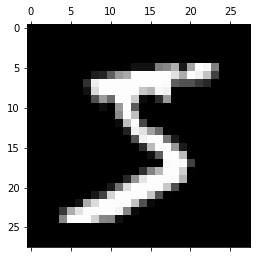

In [4]:
plt.matshow(X_train[0], cmap='gray')

Get the shape of the data

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
X_test.shape

(10000, 28, 28)

Reshape the data into 60k rows by 784 columns.

In [7]:
X_train = np.reshape(X_train, (X_train.shape[0],28*28))
X_test = np.reshape(X_test, (X_test.shape[0],28*28))

In [8]:
X_train.shape

(60000, 784)

In [9]:
def vectorize(num):
    vec=np.zeros(10)
    vec[num]=1
     
    return vec

In [10]:
y_train = (pd.Series(y_train).apply(vectorize)).to_numpy()
y_train = np.stack(y_train)

In [11]:
y_test = (pd.Series(y_test).apply(vectorize)).to_numpy()
y_test = np.stack(y_test)

Now each row of A (X_train) can have a mapping to B (y_train) by multiplication with x.

# Problem 1

## Least Squares (Minimizing 2-norm):

First trying a linear least squares solution (minimizing the 2-norm):

In [12]:
x = np.linalg.lstsq(X_train, y_train, rcond=None)

I can plot the image along with the true label and the label found by least squares solution.  
On the bottom left is the true label.   
On the bottom right is the model response label.

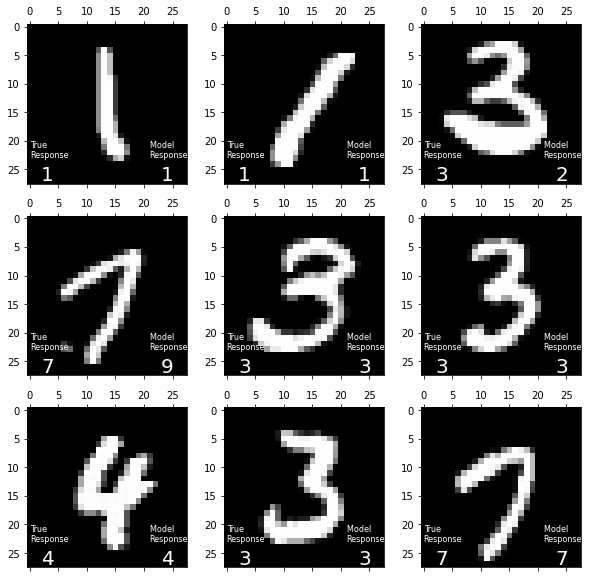

In [14]:
plt.figure(figsize=[10,10])
for i in np.arange(1,10):
    plt.subplot(3,3,i)
    check = np.random.randint(0,X_train.shape[0])
    plt.matshow(X_train[check].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,27,(X_train@x[0])[check].argmax(), fontsize=20, c='white')
    plt.text(2,27,y_train[check].argmax(), fontsize=20, c='white')
    plt.text(21,23,'Model \nResponse', fontsize=8, c='white')
    plt.text(0,23,'True \nResponse', fontsize=8, c='white')

### Test Set Performance:

Lets see how accurate the least square solve is:

In [15]:
y_pred = (X_test@x[0]).argmax(axis=1)
y_true = y_test.argmax(axis=1)

In [16]:
len([x for x in y_true-y_pred if x == 0]) / len(y_true)

0.8534

85% classification accuracy on the test set.  
I'll also plot a matrix of images with true and model responses from the test set.

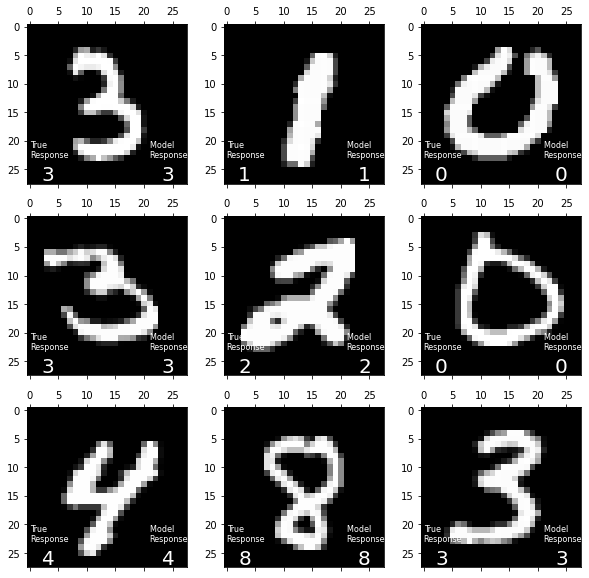

In [17]:
plt.figure(figsize=[10,10])
for i in np.arange(1,10):
    plt.subplot(3,3,i)
    check = np.random.randint(0,X_test.shape[0])
    plt.matshow(X_test[check].reshape(28,28), cmap='gray', fignum=False)
    plt.text(23,27,(X_test@x[0])[check].argmax(), fontsize=20, c='white')
    plt.text(2,27,y_test[check].argmax(), fontsize=20, c='white')
    plt.text(21,23,'Model \nResponse', fontsize=8, c='white')
    plt.text(0,23,'True \nResponse', fontsize=8, c='white')

In this case the mapping between the image space and the label space is a matrix of coefficients with shape 784x10.  
Many coefficients are not 0.

In [18]:
print('number of non-zero coefficients',len([x for x in x[0].flatten() if x != 0]))

number of non-zero coefficients 7700


## Minimizing the 1-Norm (Lasso)

Lasso regression promotes sparsity in the coefficients of a linear regression model.

In [55]:
from sklearn.linear_model import Lasso

In [56]:
# instantiate a Lasso regressor
lr = Lasso()

# fit the lasso regressor to the data
lr.fit(X_train,y_train)

# predict on the test set
y_pred = lr.predict(X_test).argmax(axis=1)

In [57]:
# Get Classification Accuracy
len([x for x in y_true-y_pred if x == 0]) / len(y_true)

0.831

83% accuracy on the test set. This shows that regularization was useful. We still dont know if the problem could use more or less regularization. The lasso model minimizes the following:

$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$

Note that the $\alpha$ parameter defines the amount of regularization to use. I'll use cross validation to find a good value for $\alpha$.

The other trouble here is that we are using a regression solver but we are ultimately interested in the model's ability to classify images of handwritten numbers correctly. This is a classification problem at the end of the day. So, I will implement a custom scoring function in the cross validation to address this unique accuracy measure.

In [58]:
from sklearn.metrics import make_scorer

# Define a scoring function that computes multi-class classification accuracy
def my_custom_loss_func(y_true, y_pred):
    
    y_pred = y_pred.argmax(axis=1)
    y_true = y_true.argmax(axis=1)
    
    return len([x for x in y_true-y_pred if x == 0]) / len(y_true)

# create a scikit-learn scorer using the custom loss function
my_scorer = make_scorer(my_custom_loss_func, greater_is_better=True)

In [59]:
from sklearn.model_selection import GridSearchCV

# build models with different values of alpha
parameters = {'alpha':[.00001,.0001,.001,.01,.1,.5,1,2]}

# instantiate a grid search cross validator with 3 folds per parameter selection
clf = GridSearchCV(lr, parameters, n_jobs=6, cv=2, verbose=10, scoring=my_scorer)

# fit the cross validator to the training set
clf.fit(X_train, y_train)

results_df = pd.DataFrame(clf.cv_results_)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  6.1min
[Parallel(n_jobs=6)]: Done   7 out of  16 | elapsed:  9.9min remaining: 12.8min
[Parallel(n_jobs=6)]: Done   9 out of  16 | elapsed: 10.4min remaining:  8.1min
[Parallel(n_jobs=6)]: Done  11 out of  16 | elapsed: 10.8min remaining:  4.9min
[Parallel(n_jobs=6)]: Done  13 out of  16 | elapsed: 10.9min remaining:  2.5min
[Parallel(n_jobs=6)]: Done  16 out of  16 | elapsed: 11.5min finished


I can plot a bias-variance curve that shows that as we increase alpha, the model begins to miss important information (too much regularization). If alpha is too low, the model does not have enough regularization and has higher variance.

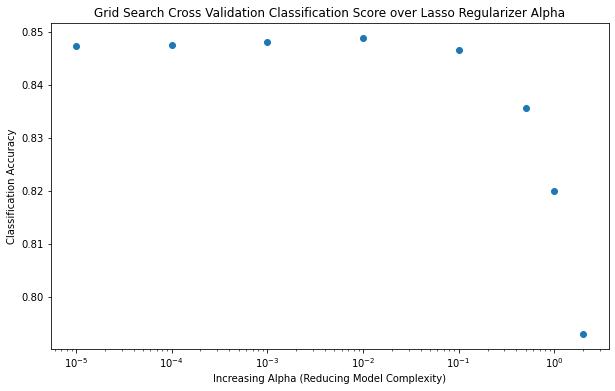

In [60]:
plt.figure(figsize=[10,6])
plt.scatter(results_df['param_alpha'], results_df['mean_test_score'])
plt.title('Grid Search Cross Validation Classification Score over Lasso Regularizer Alpha');
plt.ylabel('Classification Accuracy'); plt.xlabel('Increasing Alpha (Reducing Model Complexity)');
plt.xscale('log')

It looks like $\alpha$ of .01 is appropriate.  
I'll build a Lasso Regression model with an $\alpha$ of .01.

In [61]:
# instantiate a Lasso regressor
lr = Lasso(alpha=.01)

# fit the lasso regressor to the data
lr.fit(X_train,y_train)

# predict on the test set
y_pred = lr.predict(X_test).argmax(axis=1)

### Test Set Performance

In [62]:
len([x for x in y_true-lr.predict(X_test).argmax(axis=1) if x == 0]) / len(y_true)

0.8612

We get a 1% boost in classification accuracy performace by reducing model variance using regularization.

I can visualize the mapping from image space to label space by looking at the lasso regression coefficients.  

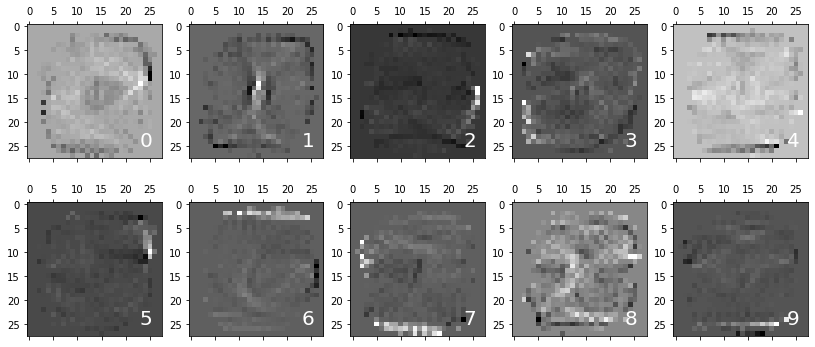

In [63]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(lr.coef_[i].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,25,i, fontsize=20, c='white')

The space around each blob of coefficients is all the same color. In this case, all of those coefficients are zero. We can surmise that the information near the edges of the image is generally not useful for determining what number is handwritten.

# Problem 2

The Lasso Regressor built in problem 1 is appropriate for promoting sparsity. It drives many coefficients to 0, especially as alpha increases. The metric for determining how important a pixel is can be determined by the magnitude of the coefficient for that given pixel.

In [64]:
print('number of non-zero coefficients',len([x for x in lr.coef_.flatten() if x != 0]))

number of non-zero coefficients 4106


In [65]:
print('% coefficients not zero = ',np.round(len([x for x in lr.coef_.flatten() if x != 0])/len(lr.coef_.flatten())*100,2))

% coefficients not zero =  52.37


Depending on the priority of speed vs accuracy, more regularization could drive more zero coefficients but at an increasing cost of accuracy. I'll increase regularization to $\alpha =1$ and see the tradeoff.

In [66]:
# instantiate a Lasso regressor
lr_a1 = Lasso(alpha=1)

# fit the lasso regressor to the data
lr_a1.fit(X_train,y_train)

print('Classification Accuracy:',len([x for x in y_true-lr_a1.predict(X_test).argmax(axis=1) if x == 0]) / len(y_true))

Classification Accuracy: 0.831


In [67]:
print('number of non-zero coefficients',len([x for x in lr_a1.coef_.flatten() if x != 0]))

number of non-zero coefficients 833


In [68]:
print('% coefficients not zero = ',np.round(len([x for x in lr_a1.coef_.flatten() if x != 0])/len(lr_a1.coef_.flatten())*100,2))

% coefficients not zero =  10.62


We get a 3 percentage point reduction in test set accuracy, but we also drive many more coefficients to 0.

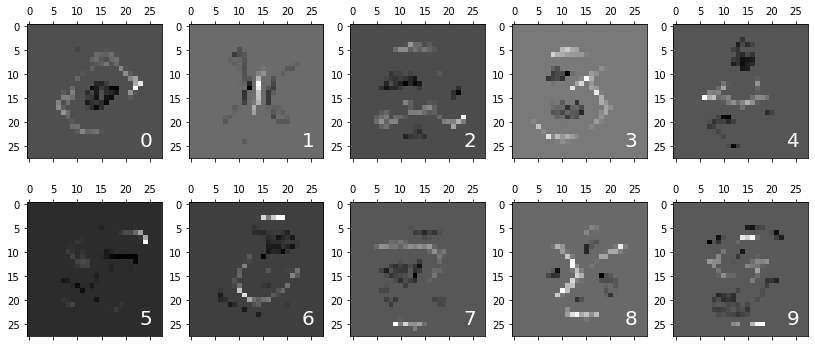

In [69]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(lr_a1.coef_[i].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,25,i, fontsize=20, c='white')

Notice how many more coefficients are 0, futher, notice how the higher coefficients (lighter) are somewhat in the shape of the expected handwritten number, and the negative coefficients (darker) are where that handwritten number generally doesn't have markings. Zero and Three show this effect very well.

I made a bias-variance curve already in part 1, so we already know we will be taking an accuracy hit going above $\alpha=.01$ but lets see what the visualization of coefficients looks like with an $\alpha=3$

In [70]:
# instantiate a Lasso regressor
lr_a3 = Lasso(alpha=3)

# fit the lasso regressor to the data
lr_a3.fit(X_train,y_train)

print('Classification Accuracy:',len([x for x in y_true-lr_a3.predict(X_test).argmax(axis=1) if x == 0]) / len(y_true))

Classification Accuracy: 0.7684


In [71]:
print('number of non-zero coefficients',len([x for x in lr_a3.coef_.flatten() if x != 0]))

number of non-zero coefficients 369


In [72]:
print('% coefficients not zero = ',np.round(len([x for x in lr_a3.coef_.flatten() if x != 0])/len(lr_a3.coef_.flatten())*100,2))

% coefficients not zero =  4.71


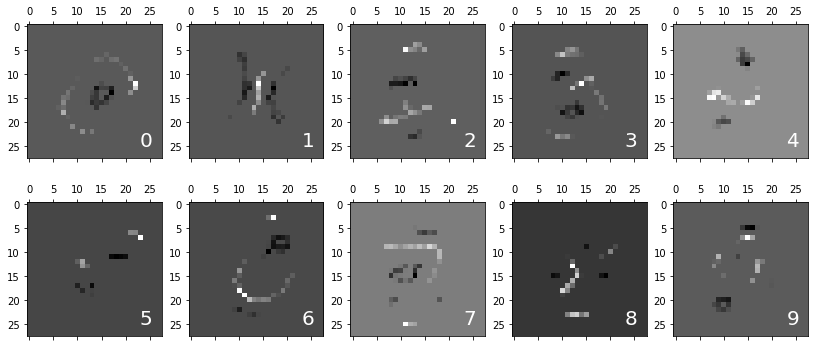

In [73]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(lr_a3.coef_[i].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,25,i, fontsize=20, c='white')

We took a big hit in accuracy,and we only reduced the % of coefficients that are not zero by 5% from the $\alpha=1$ model.  
I think $\alpha=1$ is a nice tradeoff between test set accuracy and regularization. With a classification accuracy of 83% using only 10% of the pixels.

## Ranking the Pixels

One way to rank the importance of a pixel is to utilize [permutation importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

I'll shuffle the values of each pixel in an image with the corresponding pixel in other images and see which pixels impact the prediction the most. Then we can find out which pixels being shuffled changes the predicted value.

The permutation importance in this case is defined as the the change in classification capability of model with that pixel randomly shuffled. More change means that pixel has more importance.

An alternative to permutation importance would be to use Principal Component Analysis (which relies on the SVD) to move the problem into an orthonormal lower dimensional problem by selecting only the top principal components (corresponding to the highest singular values)


In [74]:
from sklearn.inspection import permutation_importance

In [75]:
result = permutation_importance(lr_a1, 
                                X_train, 
                                y_train,
                                scoring=my_scorer,
                                n_repeats=5,
                                n_jobs=6)

Visualizing the pixel importances:

Text(0.5, 1.0, 'Pixel Importances (brighter is more important)')

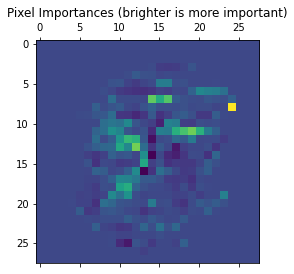

In [76]:
plt.matshow(result.importances_mean.reshape(28,28))
plt.title('Pixel Importances (brighter is more important)')

Text(0.5, 0, 'Pixel ID')

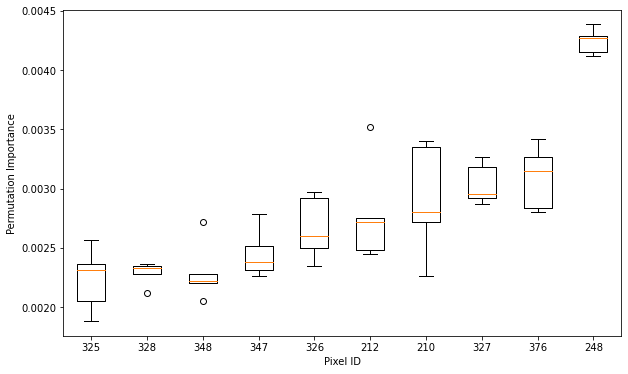

In [77]:
plt.figure(figsize=[10,6])
perm_sorted_idx = result.importances_mean.argsort()

plt.boxplot(result.importances[perm_sorted_idx].T[:,-10:],
            labels=perm_sorted_idx[-10:]);
plt.ylabel('Permutation Importance'); plt.xlabel('Pixel ID')

Text(0.5, 0, 'Pixel ID')

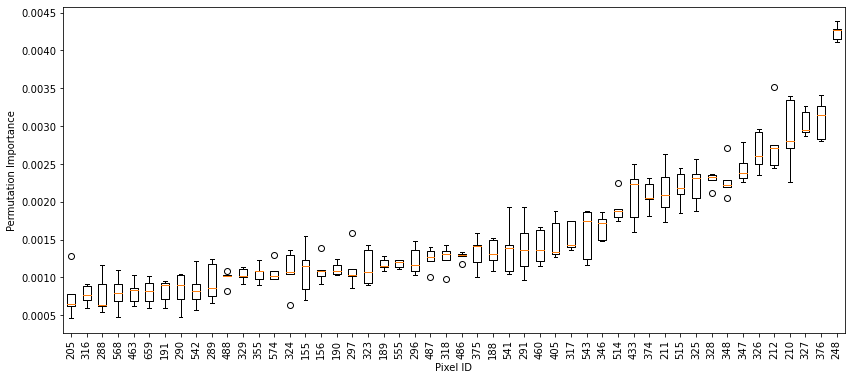

In [78]:
plt.figure(figsize=[14,6])
plt.boxplot(result.importances[perm_sorted_idx].T[:,-50:],
            labels=perm_sorted_idx[-50:]);
plt.xticks(rotation=90);
plt.ylabel('Permutation Importance'); plt.xlabel('Pixel ID')

It is interesting how predictive pixel 248 is... however, noticing how the pixel importance slowly approaches 0, it is clear that it takes many pixels to be able to tell what number is in the image reliably. The l1_a1 (Lasso with alpha=1) model relies on 833 non-zero coefficients.

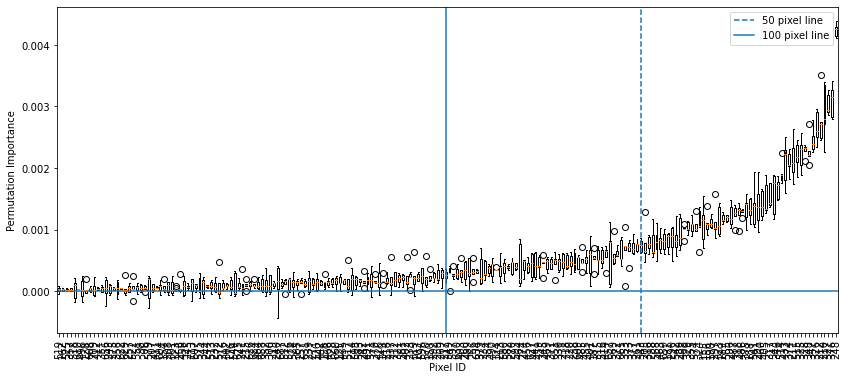

In [79]:
plt.figure(figsize=[14,6])
plt.boxplot(result.importances[perm_sorted_idx].T[:,-200:],
            labels=perm_sorted_idx[-200:]);
plt.axhline(0)
plt.axvline(150, ls='--', label='50 pixel line')
plt.axvline(100, label='100 pixel line')
plt.legend();plt.xticks(rotation=90);
plt.ylabel('Permutation Importance'); plt.xlabel('Pixel ID');

I'll take just the top 50 pixels, and see how I do.

In [80]:
# taking the top 50 pixels

top_pixels = perm_sorted_idx[-50:]

In [81]:
top_pixels

array([205, 316, 288, 568, 463, 659, 191, 290, 542, 289, 488, 329, 355,
       574, 324, 155, 156, 190, 297, 323, 189, 555, 296, 487, 318, 486,
       375, 188, 541, 291, 460, 405, 317, 543, 346, 514, 433, 374, 211,
       515, 325, 328, 348, 347, 326, 212, 210, 327, 376, 248], dtype=int64)

Lets see which ones they are visually...

In [82]:
tp_img = np.zeros(28*28);
tp_img = pd.DataFrame(tp_img, columns=['Value'])
tp_img['Value'] = np.where(tp_img.index.isin(top_pixels),1,0)

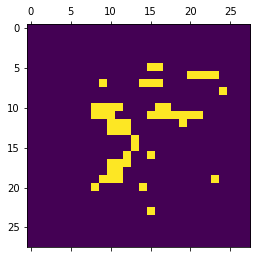

In [83]:
plt.matshow(np.array(tp_img).reshape(28,28))

# Problem 3

The 50 pixel analysis will reduce the dimensionality of the problem significantly. Where X_train (A) was previously 784 columns, it is now 50.

In [84]:
X_train_reduced = X_train[:,top_pixels].copy()
X_test_reduced = X_test[:,top_pixels].copy()

In [85]:
X_train_reduced.shape

(60000, 50)

Now I can fit a least squares regression model:

In [86]:
x_reduced = np.linalg.lstsq(X_train_reduced, y_train, rcond=None)

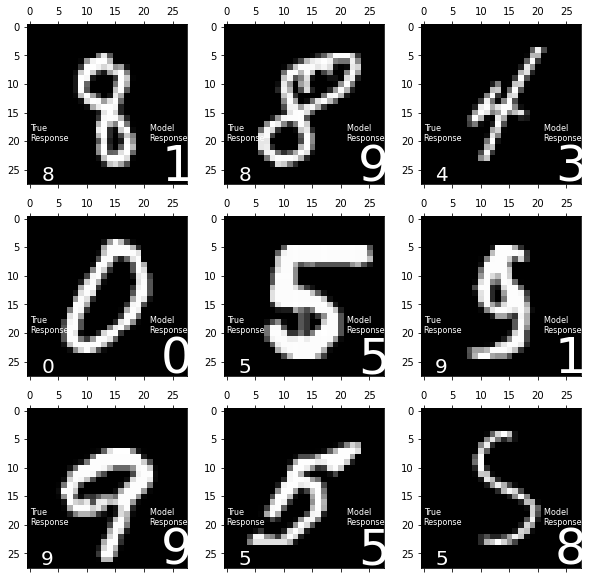

In [87]:
plt.figure(figsize=[10,10])
for i in np.arange(1,10):
    plt.subplot(3,3,i)
    check = np.random.randint(0,X_train.shape[0])
    plt.matshow(X_train[check].reshape(28,28), fignum=False, cmap='gray')
    plt.text(23,27,(X_train_reduced@x_reduced[0])[check].argmax(), fontsize=20, c='white')
    plt.text(2,27,y_train[check].argmax(), fontsize=20, c='white')
    plt.text(21,20,'Model \nResponse', fontsize=8, c='white')
    plt.text(0,20,'True \nResponse', fontsize=8, c='white')

In [88]:
y_pred_reduced = (X_test_reduced@x_reduced[0]).argmax(axis=1)

How much did we reduce the problem?

In [89]:
(X_train_reduced.shape[0]*X_train_reduced.shape[1]) / (X_train.shape[0]*X_train.shape[1])

0.06377551020408163

We lost 10% of the accuracy of our original model, but reduced dimensionality of the problem by almost 16x (the reduced problem is only 6% of the problem size)

An extension of this exercise would be to plot the accuracy as a function of pixels.

# Problem 4

The dataset will need to be broken into 10 binary classification problems. I'll use a Decision Tree, which isn't linear, but gets the job done.

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# instantiate a dictionary to hold classification models
dtrees={}

# Loop through each target (0 thru 9) and build a classification model
for i in np.arange(0,10,1):
    dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10)
    dt.fit(X_train,y_train[:,i])
    dtrees[str(i)] = dt
    print(str(i)+' Test Set Classification Accuracy:', accuracy_score(y_test[:,i], dt.predict(X_test)))

0 Test Set Classification Accuracy: 0.9881
1 Test Set Classification Accuracy: 0.991
2 Test Set Classification Accuracy: 0.9705
3 Test Set Classification Accuracy: 0.9721
4 Test Set Classification Accuracy: 0.9772
5 Test Set Classification Accuracy: 0.9753
6 Test Set Classification Accuracy: 0.9863
7 Test Set Classification Accuracy: 0.9805
8 Test Set Classification Accuracy: 0.9675
9 Test Set Classification Accuracy: 0.9686


The above 10 models take the entire X_train (A matrix) set and predict binary whether or not a given row in A is the assigned number or not. I have limited the depth and samples_per_leaf node in each tree to prevent overfitting and reduce complexity.

I'll look at the most important pixels for each model again using permutation importance.

In [91]:
results={}
for i in np.arange(0,10,1):
    results[str(i)] = permutation_importance(dtrees[str(i)], 
                                     X_train, 
                                     y_train[:,i],
                                     n_repeats=5,
                                     n_jobs=7)
    print(str(i)+' Complete.')

0 Complete.
1 Complete.
2 Complete.
3 Complete.
4 Complete.
5 Complete.
6 Complete.
7 Complete.
8 Complete.
9 Complete.


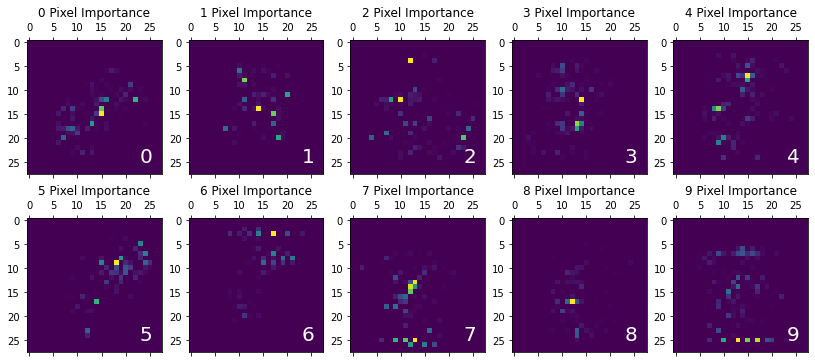

In [92]:
plt.figure(figsize=[14,6])
for i in np.arange(0,10):
    plt.subplot(2,5,i+1)
    plt.matshow(results[str(i)].importances_mean.reshape(28,28), fignum=False)
    plt.title(str(i)+' Pixel Importance')
    plt.text(23,25,i, fontsize=20, c='white')

I could now build a smaller model for each number that utilizes only the top pixels for each. This was already covered in problem 3. In summary, I have found the most important pixels for determining the number that was handwritten in the image, along with 10 similar models that predict with 96% percent accuracy whether or not the number is 0 or 1 or 2, etc.

An interesting extension of the above plot would be to see how the average importance of each pixel compares to the importance of each pixel in the model that predicts 10 different number classes.